<a href="https://colab.research.google.com/github/spotify-nlp/spotify-project/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np #lin alg
import pandas as pd # data processing

In [4]:
from google.colab import drive # Mounting google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# more imports
import matplotlib.pyplot as plt
import seaborn as sns #python data visualization library based on matplotlib
from wordcloud import WordCloud #used to analyze data from social network websites
import torch
from sklearn.model_selection import train_test_split #for splitting data
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re 
import nltk # natural language toolkit: suite of libraries/programs for symbolic/stat NLP for English
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup


In [6]:
# importing data from drive

DATASET_DIR = "/content/gdrive/MyDrive/Datasets/Spotify_emotion_data_text"
TEST_DIR = DATASET_DIR + "/test.txt"
TRAIN_DIR = DATASET_DIR + "/train.txt"
VAL_DIR = DATASET_DIR + "/val.txt"

# splitting and preparing data
test_data = pd.read_csv(TEST_DIR, header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# print(test_data[:20])
train_data = pd.read_csv(TRAIN_DIR, header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
val_data = pd.read_csv(VAL_DIR, header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)
print("Val: ", val_data.shape)

train_data.head()

Train:  (16000, 2)
Test:  (2000, 2)
Val:  (2000, 2)


,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
# trying to find correlation length and emotion
train_data['length'] = [len(x) for x in train_data["Comment"]] # creating new column length with length of comment
train_data.head(n=10)

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
5,ive been feeling a little burdened lately wasn...,sadness,65
6,ive been taking or milligrams or times recomme...,surprise,122
7,i feel as confused about life as a teenager or...,fear,73
8,i have been with petronas for years i feel tha...,joy,98
9,i feel romantic too,love,19


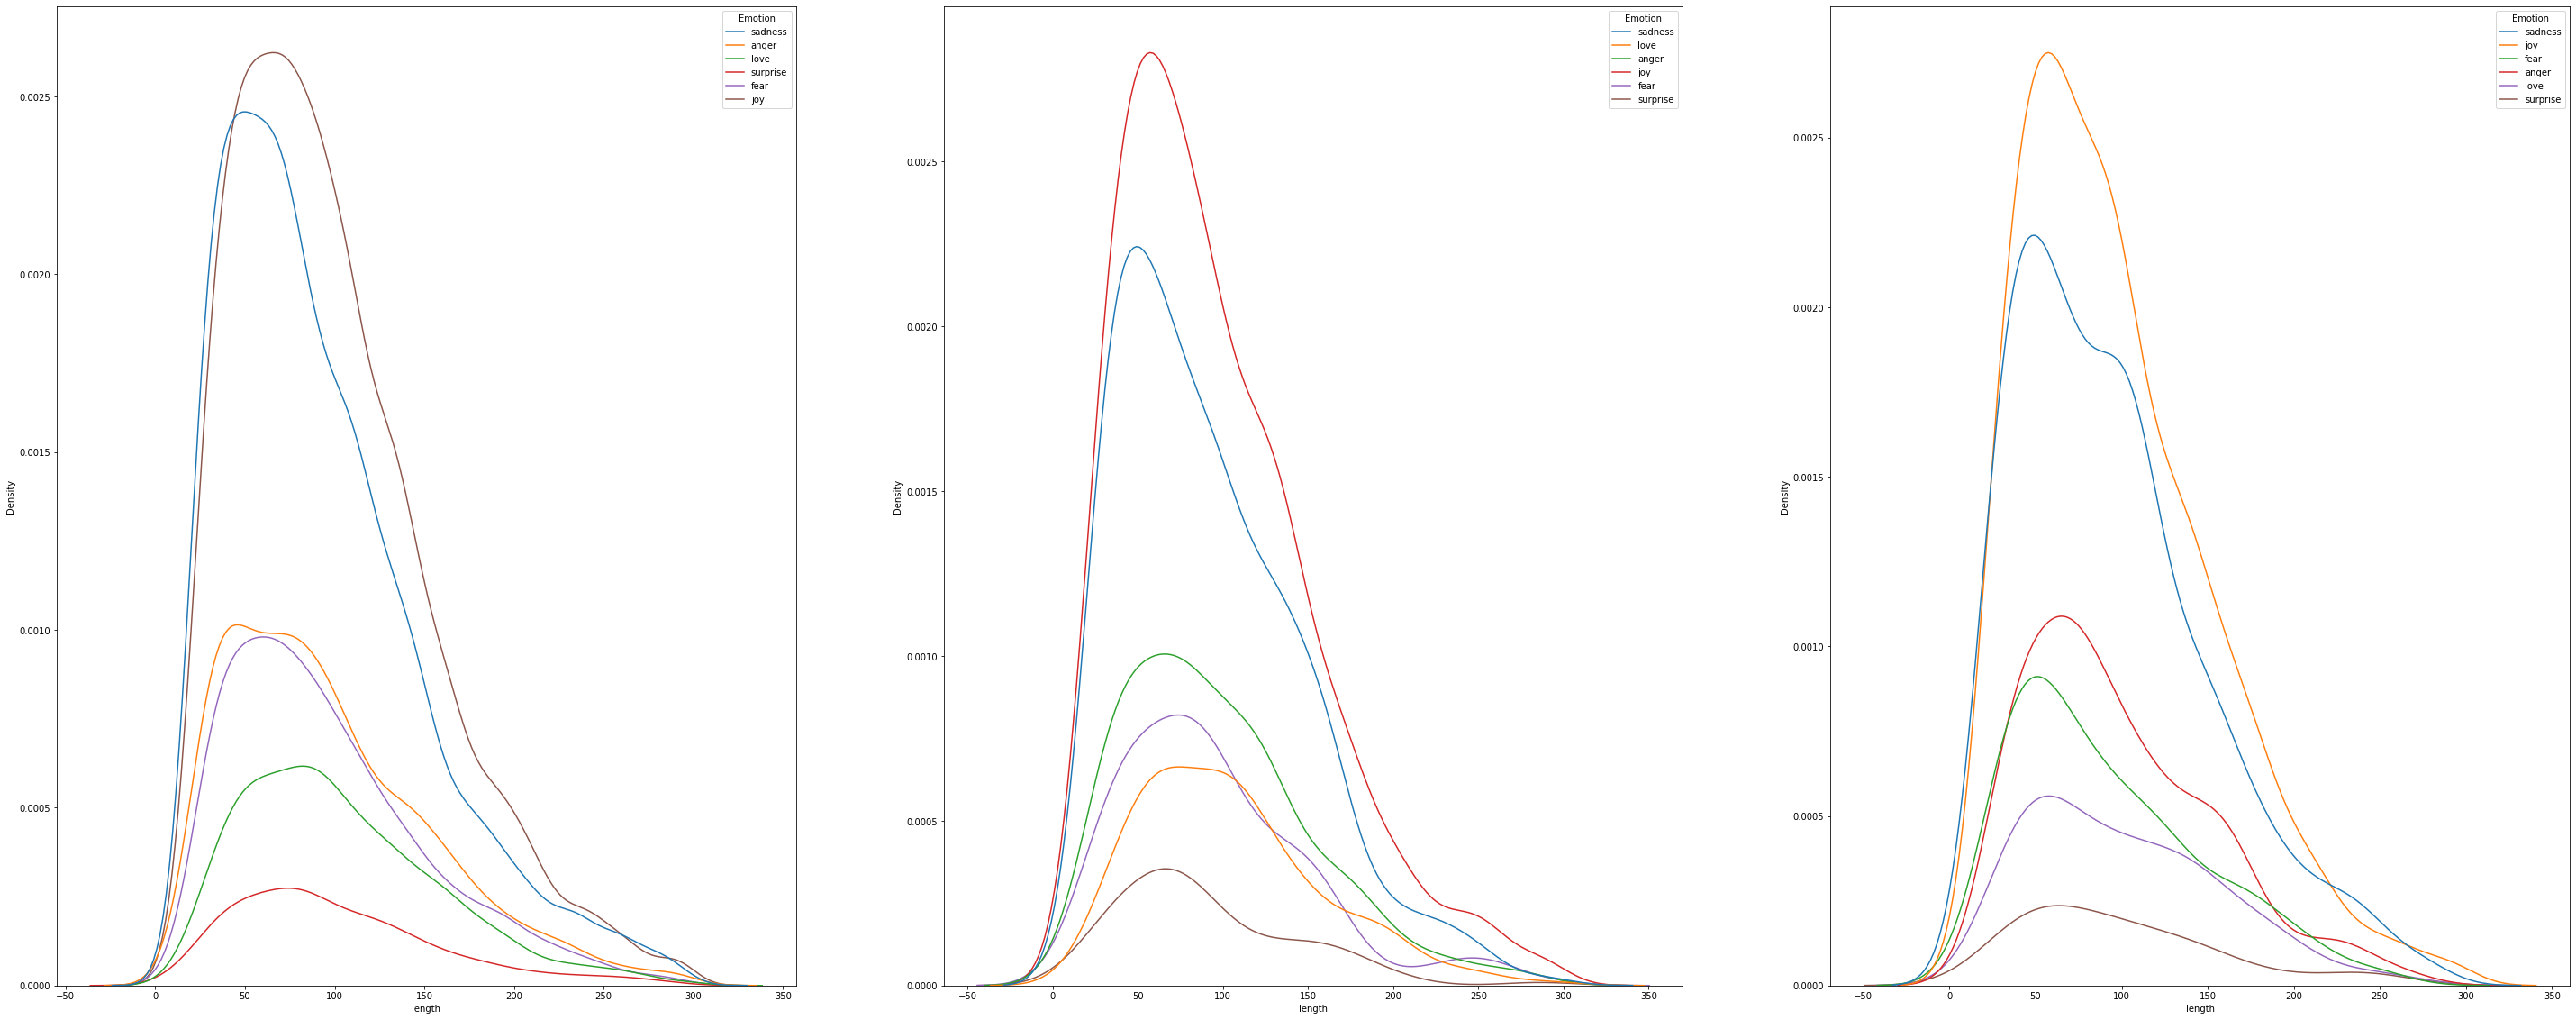

In [8]:
# preparing the data for graph visualization
all_data = {'Train Data': train_data, 'Validation Data': val_data, 'Test Data' : test_data}
fig, ax = plt.subplots(1,3, figsize=(50,20))
# subplots = multiple plots that exist on same Matplotlib figure
# nrows = 1, ncols = 3, figure size = 3o (height)

for i, df in enumerate(all_data.values()):
  df2 = df.copy()
  df2['length'] = [len(x) for x in df2["Comment"]]
  sns.kdeplot(data=df2, x="length", hue="Emotion", ax=ax[i])

plt.show()

In [9]:
# making word clouds

# creating function to call to generate word cloud for each emotion
def words_cloud(wordcloud, df):
  plt.figure(figsize=(10, 10))
  plt.title(df + " Word Cloud", size=16)
  plt.imshow(wordcloud)
  plt.axis("off")

emotions_list = train_data["Emotion"].unique()
print(emotions_list)
len(emotions_list)

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


6

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fb370174c20> (for post_execute):


KeyboardInterrupt: ignored

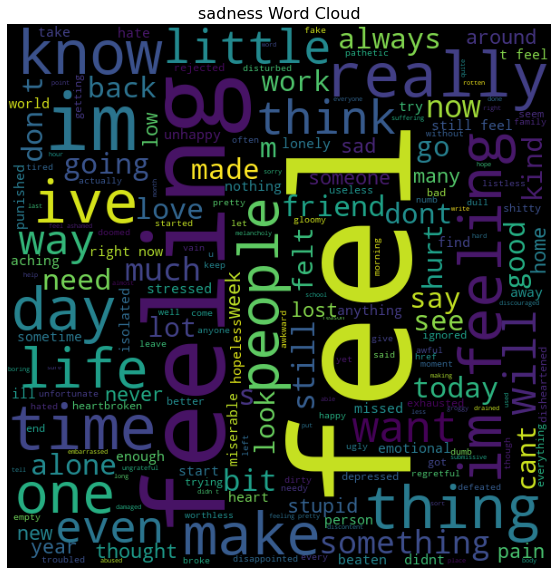

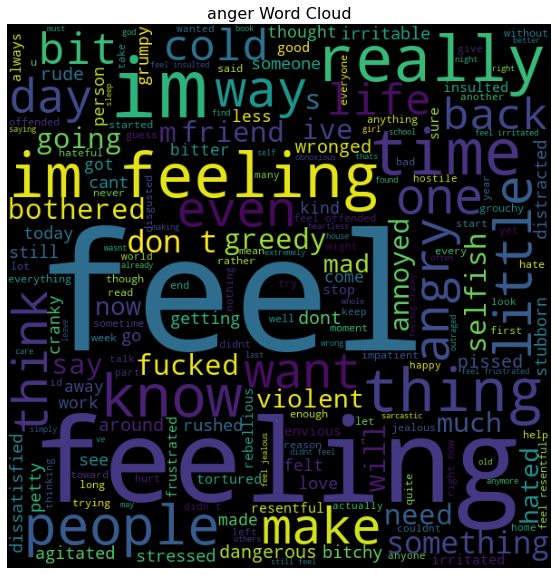

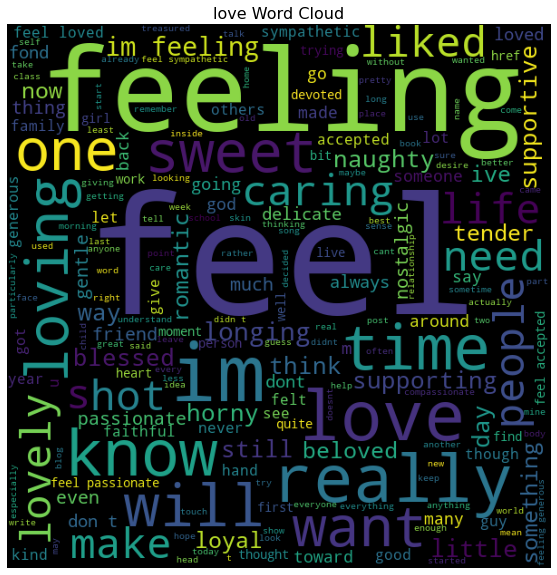

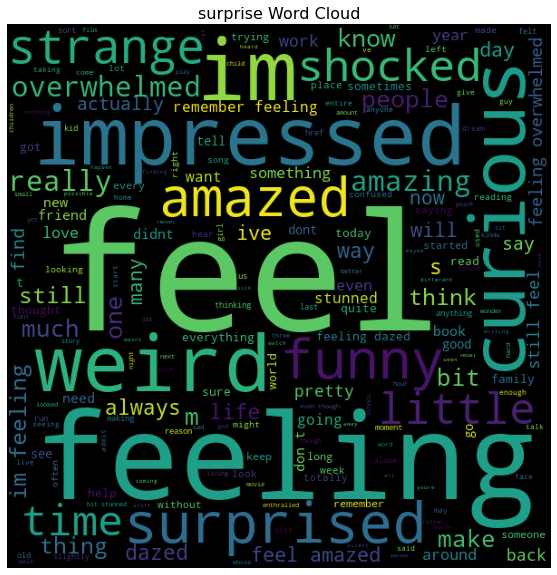

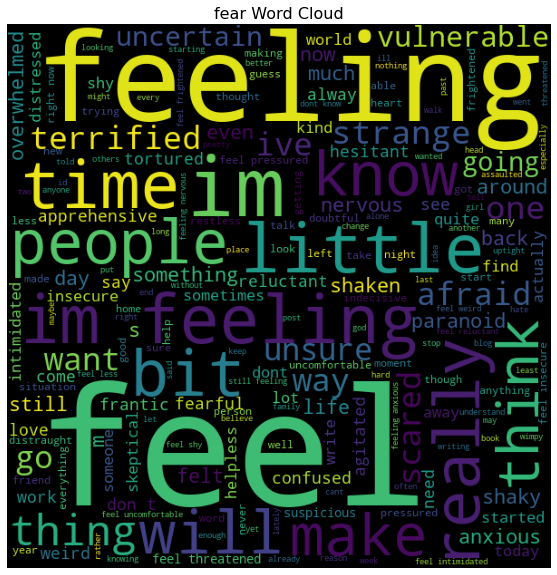

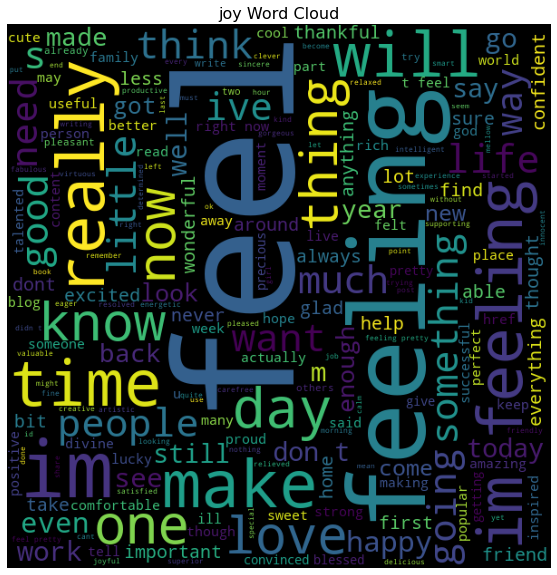

In [9]:
# this one takes a long time to run for visualizing: don't run if unnecessary
for emotion in emotions_list:
  # pretty sure just joining all sentences from that emotion into one big string for the wordcloud
  text = ' '.join([sentence for sentence in train_data.loc[train_data["Emotion"] == emotion, "Comment"]])
  wordcloud = WordCloud(width=600, height=600).generate(text) # actually generating word cloud
  # giving label and wordcloud to function
  words_cloud(wordcloud, emotion)


In [9]:
# PREPROCESSING

# Label Encoding: giving numerical value to represent distinct word
# label encoding emotion here
lb = LabelEncoder()
train_data["Emotion"] = lb.fit_transform(train_data["Emotion"])
test_data["Emotion"] = lb.fit_transform(test_data["Emotion"])
val_data["Emotion"] = lb.fit_transform(val_data["Emotion"])

train_data.head(n=10)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
5,ive been feeling a little burdened lately wasn...,4,65
6,ive been taking or milligrams or times recomme...,5,122
7,i feel as confused about life as a teenager or...,1,73
8,i have been with petronas for years i feel tha...,2,98
9,i feel romantic too,3,19


In [10]:
# cleaning data: removing unrelevent stopwords and chars
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
max_len = train_data['length'].max()
max_len

300

In [12]:
# X_train = train_data.to_numpy()
# X_train = train_data

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(pd.concat(X_train, axis=0))

In [13]:
vocabSize = 11000

from tensorflow.keras.preprocessing.text import one_hot

# df = dataframe like train_data
def text_cleaning(df, column):
  # Removing unrelevant chars, stemming, and padding
  stemmer = PorterStemmer()
  corpus = []

# stemming = process of reducing inflected/derived words to their word stem (base/root form)
  for text in df[column]:
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
  
  one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
  pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
  print(pad)
  print(pad.shape)
  return pad


In [26]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [14]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(val_data, "Comment")

[[   0    0    0 ... 8848 5294 3500]
 [   0    0    0 ...  808 2456  132]
 [   0    0    0 ... 5294 2725 1327]
 ...
 [   0    0    0 ... 1927 6135 6307]
 [   0    0    0 ... 4935 6671 5299]
 [   0    0    0 ... 5294 6780 6120]]
(16000, 300)
[[    0     0     0 ...  6671  6954  2089]
 [    0     0     0 ...  7969  5294  2490]
 [    0     0     0 ...  5294  6801  6530]
 ...
 [    0     0     0 ...  2810  5294 10615]
 [    0     0     0 ... 10187  2650 10619]
 [    0     0     0 ...  4586  4586  2824]]
(2000, 300)
[[    0     0     0 ...  3226  8312  9648]
 [    0     0     0 ...  2187  4885  5152]
 [    0     0     0 ...  6801  6637   620]
 ...
 [    0     0     0 ...  6643  1780 10181]
 [    0     0     0 ...  5135  5338  3774]
 [    0     0     0 ...  6131   577  4134]]
(2000, 300)


In [15]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = val_data["Emotion"]

In [16]:
# to categorical: the numpy vector that contains integers representing diff categories
#   becomes 2D matrix having binary values with the position of the 1 representing the category number
# eg. [2, 3, 1] -->
# [0 0 1 0
#  0 0 0 1 
#  0 1 0 0]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

**Model Building**

In [17]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize, output_dim=150, input_length=300))
model.add(Dropout(0.2))
# LSTM = Long Short-Term Memory layer
# layer will choose diff implementations to maximize performance
# 128 = units: dimensionality of output space
model.add(LSTM(128))
model.add(Dropout(0.2))
# regular Dense layer
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(6, activation="softmax"))


In [18]:
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1650000   
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [19]:
# stops training when a monitored metric stops improving: here, goal is to minimize loss
callback = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)

In [20]:
hist = model.fit(x_train, y_train, epochs=10,batch_size=64,
                 validation_data=(x_val, y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 12s 21ms/step - loss: 1.4564 - accuracy: 0.4277 - val_loss: 1.0472 - val_accuracy: 0.6495
Epoch 2/10
250/250 [==============================] - 4s 17ms/step - loss: 0.5495 - accuracy: 0.8179 - val_loss: 0.3814 - val_accuracy: 0.8700
Epoch 3/10
250/250 [==============================] - 4s 17ms/step - loss: 0.2722 - accuracy: 0.9104 - val_loss: 0.3629 - val_accuracy: 0.8830
Epoch 4/10
250/250 [==============================] - 4s 17ms/step - loss: 0.1874 - accuracy: 0.9351 - val_loss: 0.3076 - val_accuracy: 0.8985
Epoch 5/10
250/250 [==============================] - 4s 17ms/step - loss: 0.1393 - accuracy: 0.9535 - val_loss: 0.3161 - val_accuracy: 0.8995


In [21]:
model.evaluate(x_val, y_val, verbose=1)

63/63 [==============================] - 1s 9ms/step - loss: 0.3076 - accuracy: 0.8985


[0.30761197209358215, 0.8985000252723694]

In [22]:
model.evaluate(x_test, y_test,verbose=1)

63/63 [==============================] - 1s 10ms/step - loss: 0.3140 - accuracy: 0.8920


[0.31395459175109863, 0.8920000195503235]

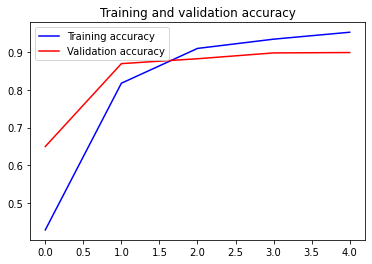

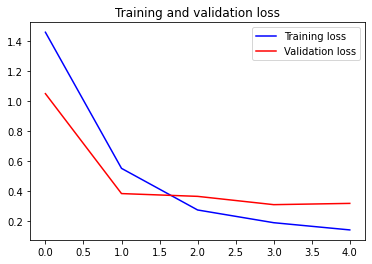

In [23]:
# visualizing it all
accuracy = hist.history['accuracy']
val_acc = hist.history["val_accuracy"]
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label="Training accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
def sentence_cleaning(sentence):
  # pre-processing sentence for prediction
  stemmer = PorterStemmer()
  corpus = []
  text = re.sub("[^a-zA-Z]", " ", sentence)
  text = text.lower()
  text = text.split()
  text = [stemmer.stem(word) for word in text if word not in stopwords]
  text = " ".join(text)
  corpus.append(text)
  one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
  pad = pad_sequences(sequences=one_hot_word, maxlen=max_len,padding='pre')
  return pad

In [25]:
sentences = [
     "He was speechless when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring"
]

for sentence in sentences:
  print(sentence)
  sentence = sentence_cleaning(sentence)
  result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))
  print(result)
  # proba = np.max(model.predict(sentence))
  # print(f"{result} : {proba}\n\n")

He was speechless when he found out he was accepted to this new job
['joy']
This is outrageous, how can you talk like that?
['anger']
I feel like im all alone in this world
['sadness']
He is really sweet and caring
['love']


**Saving the model**

In [54]:
# importing pickle
import pickle
# pickle_file = os.path.join(DATASET_DIR, '/model.pkl')
pickle_out = open(DATASET_DIR + '/model.pickle', 'wb')
# pickle.dump(X,)
pickle.dump(model, pickle_out)
pickle_out.close()

INFO:tensorflow:Assets written to: ram://b7246525-d678-4781-9ecf-34b346eda0be/assets


INFO:tensorflow:Assets written to: ram://b7246525-d678-4781-9ecf-34b346eda0be/assets


In [56]:
pickle_in = open(DATASET_DIR + '/model.pickle', 'rb')
pickle_model = pickle.load(pickle_in)
pickle_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 150)          1650000   
                                                                 
 dropout_12 (Dropout)        (None, 300, 150)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 6)                

In [57]:
for sentence in sentences:
  print(sentence)
  sentence = sentence_cleaning(sentence)
  result = lb.inverse_transform(np.argmax(pickle_model(sentence), axis=-1))[0]
  proba = np.max(pickle_model.predict(sentence))
  print(f"{result} : {proba}\n\n")

He was speechless when he found out he was accepted to this new job
joy : 0.4243021607398987


This is outrageous, how can you talk like that?
anger : 0.7542161345481873


I feel like im all alone in this world
sadness : 0.9696245789527893


He is really sweet and caring
love : 0.6821255683898926


